In [1]:
%matplotlib inline
#import ipywidgets as widgets
#from ipywidgets import interact
import numpy as np
import matplotlib.pyplot as pl
#from scipy.spatial.distance import cdist
#from numpy.linalg import inv
#import george
#from george.kernels import ExpSine2Kernel, ExpSquaredKernel
import astropy
from astropy.io import fits
import celerite
from celerite import terms

Formerly was following Suzanne Aigrain's LSST tutorial on GPs: https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/blob/master/Session4/Day2/GPLecture1.ipynb

And Dan Foreman-Mackey's george tutorial:
https://george.readthedocs.io/en/latest/tutorials/first/

Since then have been following Dan Foreman-Mackey et al.'s celerite tutorial: 
https://celerite.readthedocs.io/en/stable/tutorials/first/

# 1) Inspect the data

Downloaded directly from https://archive.stsci.edu/k2/preview.php?dsn=ktwo246301900-c12&type=lc

In [2]:
import pandas as pd

ts = pd.read_csv('/Users/chris/Desktop/superflares/c12/246300000/01900/ts.txt', sep=", ", header=0)
ts.columns = ["BJD - 2454833", "Corrected Flux"] 
print(ts.head())
print(ts.tail())

   BJD - 2454833  Corrected Flux
0    2905.581553        0.984912
1    2905.601985        0.985306
2    2905.622418        0.985967
3    2905.642850        0.985878
4    2905.663282        0.986161
      BJD - 2454833  Corrected Flux
3348    2984.161921        1.039136
3349    2984.182353        1.038834
3350    2984.202784        1.044875
3351    2984.223216        1.042245
3352    2984.243648        1.041783


/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


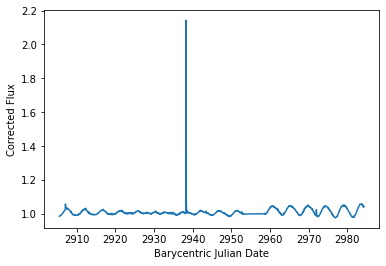

In [3]:
pl.plot(ts["BJD - 2454833"], ts["Corrected Flux"])
pl.xlabel("Barycentric Julian Date")
pl.ylabel("Corrected Flux")
pl.show()
#pl.savefig("fig1.pdf")

There are index gaps in this data format, so let's go to the more "raw" fits files from the same source.

In [4]:
filename = '/Users/chris/Desktop/superflares/ktwo246301900-c12_llc.fits'
hdul = fits.open(filename)
hdul.info()

Filename: /Users/chris/Desktop/superflares/ktwo246301900-c12_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      54   ()      
  1  LIGHTCURVE    1 BinTableHDU    155   3862R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        48   (10, 8)   int32   


In [5]:
hdu = hdul[1]
#hdu.header

In [6]:
data = fits.getdata(filename,header=True,ext=1)
df = pd.DataFrame(np.array(data[0]).byteswap().newbyteorder()) # to avoid big-endian/little-endian mixup: https://stackoverflow.com/questions/30283836/creating-pandas-dataframe-from-numpy-array-leads-to-strange-errors
print(df.head())

          TIME  TIMECORR  CADENCENO     SAP_FLUX  SAP_FLUX_ERR       SAP_BKG  \
0  2905.377230  0.005332     136855  614164.8125     22.716827  19529.195312   
1  2905.397662  0.005331     136856  614196.0000     22.708811  19530.005859   
2  2905.418095  0.005329     136857  614179.6250     22.713530  19541.736328   
3  2905.438527  0.005328     136858  614099.5000     22.717106  19533.994141   
4  2905.458959  0.005327     136859  614238.1875     22.723835  19532.445312   

   SAP_BKG_ERR  PDCSAP_FLUX  PDCSAP_FLUX_ERR  SAP_QUALITY  PSF_CENTR1  \
0     7.201994          NaN              NaN       524288         NaN   
1     7.175916  612915.2500        22.353420            0         NaN   
2     7.180060  612892.8125        22.366695            0         NaN   
3     7.191803  612824.8125        22.378389            0         NaN   
4     7.191343  612975.3750        22.391329            0         NaN   

   PSF_CENTR1_ERR  PSF_CENTR2  PSF_CENTR2_ERR  MOM_CENTR1  MOM_CENTR1_ERR  \
0  

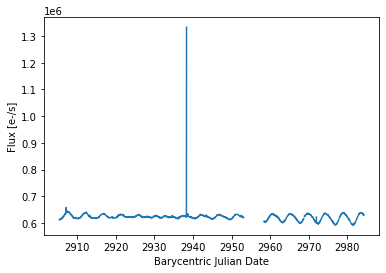

In [7]:
pl.plot(df.TIME, df.PDCSAP_FLUX)
pl.xlabel("Barycentric Julian Date")
pl.ylabel("Flux [e-/s]")
pl.show()

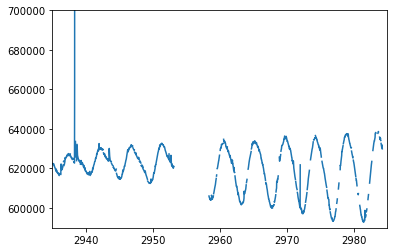

In [8]:
# examine the gap
pl.plot(df.TIME, df.PDCSAP_FLUX)
pl.xlim([2935,2985])
pl.ylim([590000,700000])
pl.show()

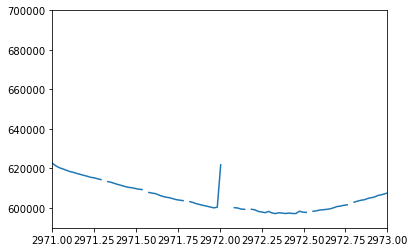

3256    601289.4375
3257    600915.5625
3258    600486.1250
3259    600089.1250
3260    600415.0000
3261    621832.1875
3262            NaN
3263            NaN
3264            NaN
3265    600196.0000
Name: PDCSAP_FLUX, dtype: float32


In [9]:
# examine spike/possible flare shortly after 2970 BJD
pl.plot(df.TIME, df.PDCSAP_FLUX)
pl.xlim([2971,2973])
pl.ylim([590000,700000])
pl.show()

print(df.loc[(df.TIME>2971.9) & (df.TIME<2972.1)].PDCSAP_FLUX)
# ...classic, NaNs right where I need data

# 2) GP Modeling

3255


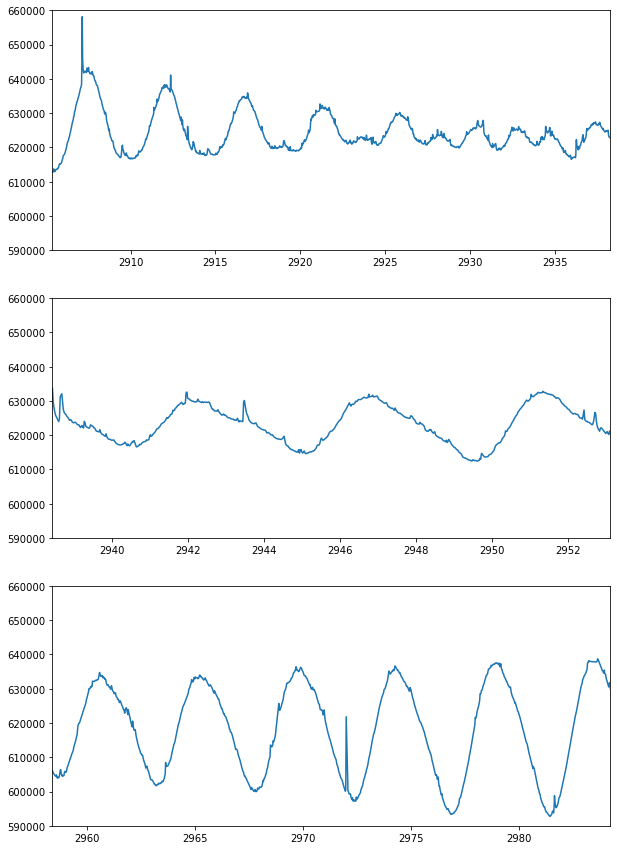

In [10]:
# divide data into pre-flare, post-flare/pre-gap, and post-flare/post-gap
df = pd.DataFrame(np.array(data[0]).byteswap().newbyteorder())
df = df.dropna(subset=['TIME','PDCSAP_FLUX','PDCSAP_FLUX_ERR']) # toss NaNs since they'll create matrices of NaNs
print(len(df))

pre = df.loc[:1611] # next record is the beginning of the flare, so stop here
post = df.loc[1614:2336] # start from after the flare until beginning of the gap in time series data
postgap = df.loc[2337:] # start from end of the gap in data until end of time series data

pl.figure(figsize=(10,15))
pl.subplot(311)
xobs = np.array(pre["TIME"])
yobs = np.array(pre["PDCSAP_FLUX"])
pl.xlim(min(pre.TIME),max(pre.TIME))
pl.ylim(590000,660000)
pl.plot(xobs,yobs)

pl.subplot(312)
xobs = np.array(post["TIME"])
yobs = np.array(post["PDCSAP_FLUX"])
pl.xlim(min(post.TIME),max(post.TIME))
pl.ylim(590000,660000)
pl.plot(xobs,yobs)

pl.subplot(313)
xobs = np.array(postgap["TIME"])
yobs = np.array(postgap["PDCSAP_FLUX"])
pl.xlim(min(postgap.TIME),max(postgap.TIME))
pl.ylim(590000,660000)
pl.plot(xobs,yobs)
pl.show()

In [281]:
""""
# custom rotation term to compare against SHO...it still seems to overfit
class RotationTerm(terms.Term):
    parameter_names = ("log_amp", "log_timescale", "log_period", "log_factor")
    def get_real_coefficients(self, params):
        log_amp, log_timescale, log_period, log_factor = params
        f = np.exp(log_factor)
        return (
           np.exp(log_amp) * (1.0 + f) / (2.0 + f),  
           np.exp(-log_timescale),
        )    

    def get_complex_coefficients(self, params):
        log_amp, log_timescale, log_period, log_factor = params
        f = np.exp(log_factor)
        return (
           np.exp(log_amp) / (2.0 + f),  
           0.0, 
           np.exp(-log_timescale),
           2*np.pi*np.exp(-log_period),
        )
"""

# Alias data
lhs = min(pre.TIME)
rhs = max(pre.TIME)
xobs = np.array(pre["TIME"])
yobs = np.array(pre["PDCSAP_FLUX"])
eobs = np.array(pre["PDCSAP_FLUX_ERR"])
print(yobs)
print(eobs)

# Straight from the celerite tutorial: the model is two stochastically driven SHOs summed together
# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 30.0 # made this one order of magnitude larger to keep parameters within similar orders for convergence
S0 = np.var(yobs) / (w0 * Q)
print(S0)
bounds = dict(log_S0=(-17, 17), log_Q=(-15, 15), log_omega0=(-15, 15)) # modified for big y values
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# A periodic component
Q = 1.0
w0 = 3.0
S0 = np.var(yobs) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

[612915.25 612892.8  612824.8  ... 622910.75 622810.2  622744.44]
[22.35342  22.366695 22.37839  ... 22.937845 22.940638 22.949953]
1634918.936467782


In [282]:
kernel

(SHOTerm(14.307103780942326, -0.34657359027997275, 3.4011973816621555) + SHOTerm(16.263115283656397, 0.0, 1.0986122886681098))

In [283]:
gp = celerite.GP(kernel, mean=np.mean(yobs))
gp.compute(xobs, eobs)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(yobs)))

Initial log likelihood: -13373.071144057343


In [284]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(yobs, gp))
gp.set_parameter_vector(r.x)
print(r)

      fun: 11933.302910860075
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.05984475,  0.1882654 , -0.02783054, -0.20227162,  0.90785761])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 294
      nit: 31
     njev: 49
   status: 0
  success: True
        x: array([ 9.23819911,  4.2018645 , 15.8988508 ,  0.98749064,  0.46240193])


In [285]:
gp.log_likelihood(yobs)

-11933.302910860075

In [286]:
kernel

(SHOTerm(9.238199111661947, -0.34657359027997275, 4.201864499752167) + SHOTerm(15.898850801466427, 0.9874906415448854, 0.4624019280061182))

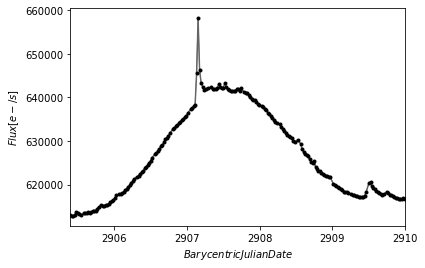

[612915.25 612892.8  612824.8  ... 622910.75 622810.2  622744.44]
[612915.44739114 612892.84937962 612824.75644721 ... 622910.74488304
 622810.40153784 622744.597936  ]


In [287]:
# Inference
pred_mean, pred_var = gp.predict(yobs, xobs, return_var=True)

# Plotting
pl.fill_between(xobs, pred_mean - np.sqrt(pred_var), pred_mean + np.sqrt(pred_var),
                color="k", alpha=0.2)
pl.plot(xobs, pred_mean, "k", lw=1.5, alpha=0.5)
pl.errorbar(xobs, yobs, yerr=eobs, fmt=".k", capsize=0)
pl.xlim(lhs, rhs)
pl.xlim(lhs,2910)
#pl.ylim(600000,650000)
pl.xlabel(r'$Barycentric Julian Date$')
pl.ylabel(r'$Flux [e-/s]$')
#pl.scatter(xobs, yobs, s=5)
pl.show()

print(yobs)
print(pred_mean)

It's really hard to get SHO terms to ignore outliers. No matter what omega or S params I change, the model is still ultra-sensitivite to them. I may come back to this later.

## George GP Implementation

In [72]:
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(yobs)))


Initial ln-likelihood: -710392.28


In [73]:
from scipy.optimize import minimize

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(yobs)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(yobs)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(yobs)))

      fun: 16244.409415096598
 hess_inv: array([[4.98384070e-04, 2.24060960e-05],
       [2.24060960e-05, 2.04840753e-05]])
      jac: array([ 7.03181528e-05, -2.12669373e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 92
      nit: 23
     njev: 80
   status: 2
  success: False
        x: array([25.56420074, -6.36906741])

Final ln-likelihood: -16244.41


[612915.23471055 612892.86080277 612824.71569698 ... 623460.19345036
 623547.34658319 623188.29980095]


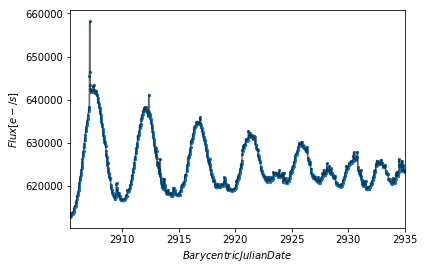

In [75]:
pred, pred_var = gp.predict(yobs, xobs, return_var=True)
print(pred)
pl.fill_between(xobs, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
pl.plot(xobs, pred, "k", lw=1.5, alpha=0.5)
#pl.errorbar(xobs, yobs, yerr=yobs, fmt=".k", capsize=0)
pl.xlim(lhs, rhs)
#pl.xlim(lhs,2910)
#pl.ylim(600000,650000)
pl.xlabel(r'$Barycentric Julian Date$')
pl.ylabel(r'$Flux [e-/s]$')
pl.scatter(xobs, yobs, s=5)
pl.show()

I'm overfitting. Let's just use the original untrained GP model.

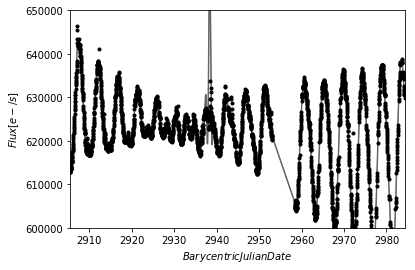

[612915.25 612892.8  612824.8  ... 631796.75 630745.4  629945.5 ]
[613084.79516003 613013.08159258 612979.80003457 ... 630703.60883033
 630441.06875551 630194.14977449]


In [81]:
kernel = np.var(yobs) * ExpSquaredKernel(0.5)
gp = george.GP(kernel)
gp.compute(xobs, eobs)

x_pred = np.linspace(0, 10, 500)
pred, pred_var = gp.predict(yobs, xobs, return_var=True)

pl.fill_between(xobs, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
pl.plot(xobs, pred, "k", lw=1.5, alpha=0.5)
pl.errorbar(xobs, yobs, yerr=eobs, fmt=".k", capsize=0)
pl.xlim(lhs, rhs)
#pl.xlim(lhs,2910)
pl.ylim(600000,650000)
pl.xlabel(r'$Barycentric Julian Date$')
pl.ylabel(r'$Flux [e-/s]$')
pl.scatter(xobs, yobs, s=5)
pl.show()

print(yobs)
print(pred)